In [32]:
import sys
sys.path.append('../../')
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import sfp_nsd_utils as utils

In [6]:
sn = 1
subj = utils.sub_number_to_string(sn)
df_path = '/Volumes/server/Projects/sfp_nsd/natural-scenes-dataset/derivatives/subj_dataframes/for_MATLAB'
df = utils.load_df(sn, df_dir=df_path, df_name='mean_df_across_phase.csv')

In [7]:
df.head()

,voxel,avg_betas,hemi,visualrois,eccrois,eccentricity,angle,size,names_idx,w_r,w_a,freq_lvl,local_ori,local_sf
0,0,1.741667,1,2.0,3.0,1.370705,292.141510,84.840942,0,0.0,6.0,0,0.386442,0.696670
1,1,1.309167,1,2.0,3.0,1.270235,291.033051,170.579865,0,0.0,6.0,0,0.367096,0.751774
2,2,0.943750,1,2.0,3.0,1.153417,288.243500,220.494080,0,0.0,6.0,0,0.318409,0.827913
3,3,1.694167,1,2.0,3.0,1.270225,293.453308,180.973740,0,0.0,6.0,0,0.409337,0.751780
4,4,1.639167,1,2.0,3.0,1.247216,293.439117,249.670349,0,0.0,6.0,0,0.409090,0.765649


In [9]:
new_df = df.query('voxel== 1 | voxel== 2')

In [16]:
sf_values = torch.from_numpy(new_df['local_sf'].values)

In [17]:
ecc_values = torch.from_numpy(new_df['eccentricity'].values)

In [36]:
ecc_values

tensor([1.2702, 1.1534, 1.2702, 1.1534, 1.2702, 1.1534, 1.2702, 1.1534, 1.2702,
        1.1534, 1.2702, 1.1534, 1.2702, 1.1534, 1.2702, 1.1534, 1.2702, 1.1534,
        1.2702, 1.1534, 1.2702, 1.1534, 1.2702, 1.1534, 1.2702, 1.1534, 1.2702,
        1.1534, 1.2702, 1.1534, 1.2702, 1.1534, 1.2702, 1.1534, 1.2702, 1.1534,
        1.2702, 1.1534, 1.2702, 1.1534, 1.2702, 1.1534, 1.2702, 1.1534, 1.2702,
        1.1534, 1.2702, 1.1534, 1.2702, 1.1534, 1.2702, 1.1534, 1.2702, 1.1534,
        1.2702, 1.1534], dtype=torch.float64)

In [18]:
beta_values = torch.from_numpy(new_df['avg_betas'].values)

In [19]:
class SFModel(torch.nn.Module):
    def __init__(self):
        # this runs the initialization code for torch.nn.Module
        super().__init__()
        # by marking something as a parameter, we're making it clear that this is what we want to update
        self.sigma = torch.nn.Parameter(torch.rand(1, dtype=torch.float32))
        self.slope = torch.nn.Parameter(torch.rand(1, dtype=torch.float32))
        self.intercept = torch.nn.Parameter(torch.rand(1, dtype=torch.float32))

    def forward(self, ecc, sf):
        p_v = self.slope * ecc + self.intercept
        b_v = torch.exp(-(torch.log2(sf) + torch.log2(p_v))**2 / 2*(self.sigma**2))
        return b_v

In [20]:
test_model = SFModel()

In [22]:
test_model(ecc_values, sf_values) # predictions of params

tensor([0.9911, 0.9881, 0.9967, 0.9948, 0.9911, 0.9881, 0.9967, 0.9948, 0.7961,
        0.7846, 0.8446, 0.8341, 0.7961, 0.7846, 0.8446, 0.8341, 0.4812, 0.4689,
        0.4865, 0.4742, 0.4812, 0.4689, 0.4865, 0.4742, 0.2128, 0.2050, 0.2149,
        0.2070, 0.2128, 0.2050, 0.2149, 0.2070, 0.2149, 0.2070, 0.2149, 0.2070,
        0.2149, 0.2070, 0.2149, 0.2070, 0.0684, 0.0651, 0.0678, 0.0646, 0.0684,
        0.0651, 0.0678, 0.0646, 0.0164, 0.0154, 0.0161, 0.0152, 0.0164, 0.0154,
        0.0161, 0.0152], dtype=torch.float64, grad_fn=<ExpBackward0>)

In [23]:
beta_values

tensor([ 1.3092,  0.9437,  1.3158,  0.8783,  0.5371,  0.3146,  1.1179,  0.7517,
         1.3175,  0.7254,  1.1025,  0.7346,  1.1658,  0.7808,  1.2162,  0.8121,
         0.9221,  0.8204,  1.0375,  0.6450,  1.0612,  0.7579,  2.0783,  1.5275,
         1.2912,  1.0858,  0.8196,  0.5683,  0.7317,  0.5229,  1.4708,  0.9600,
         1.8071,  1.3808,  0.9083,  0.4833,  0.8867,  0.4783,  0.9825,  0.9183,
         0.4808,  0.1158,  1.6104,  1.0492,  1.1842,  0.8471,  1.0708,  0.6396,
         0.5367,  0.2817,  0.0667, -0.1167, -0.1496, -0.3254,  0.9363,  0.6158],
       dtype=torch.float64)

In [24]:
def obj_func(x, y):
    # we have to use torch.mean (instead of np.mean) but the basic arithmetic symbols (-, +, **, etc) are all fine
    return torch.mean((x-y)**2)

In [25]:
obj_func(beta_values, test_model(ecc_values, sf_values))

tensor(0.4600, dtype=torch.float64, grad_fn=<MeanBackward0>)

In [27]:
optimizer = torch.optim.Adam(test_model.parameters(), lr=1e-2)

In [30]:
losses = []
param_vals = []
pbar = range(100)
for i in pbar:
    # these next four lines are the core of the loop:
    # 1. generate the prediction
    y_pred = test_model.forward(ecc_values, sf_values)
    # 2. compute the loss
    loss = obj_func(beta_values, y_pred)
    # 3. compute all the gradients ("run the backwards pass")
    loss.backward()
    # 4. update all the parameters ("step the optimizer")
    optimizer.step()
    # these next lines are just to keep track of the loss and parameter values over time
    # .item() and .clone().detach() do the same thing -- make sure that we just get the *value*,
    # rather than the *object* itself (which will update on each loop) (.item() only works for scalars)
    losses.append(loss.item())
    param_vals.append(test_model.sigma.clone().detach())
    #pbar.set_postfix(loss=losses[-1], params=param_vals[-1])
# turn this list of 1d tensors into one 2d tensor
param_vals = torch.stack(param_vals)

Text(0.5, 1.0, 'Loss')

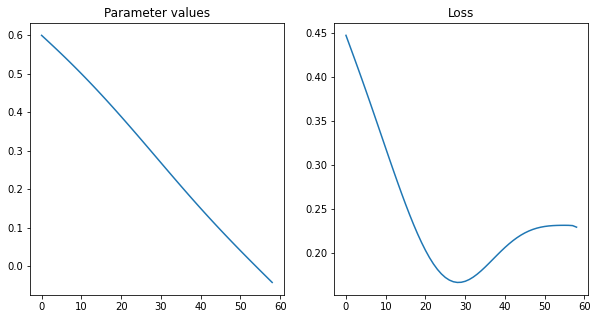

In [33]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].plot(param_vals)
axes[0].set_title('Parameter values')
axes[1].plot(losses)
axes[1].set_title("Loss")

In [35]:
param_vals # keep track of predictions as well. try with simulated data to check the model (1 without noise, and then 2 with noise, and 3 then increase noise to see when the model fails.)

tensor([[ 0.5997],
        [ 0.5901],
        [ 0.5806],
        [ 0.5709],
        [ 0.5611],
        [ 0.5513],
        [ 0.5413],
        [ 0.5312],
        [ 0.5210],
        [ 0.5107],
        [ 0.5002],
        [ 0.4896],
        [ 0.4789],
        [ 0.4680],
        [ 0.4571],
        [ 0.4460],
        [ 0.4347],
        [ 0.4234],
        [ 0.4120],
        [ 0.4005],
        [ 0.3888],
        [ 0.3771],
        [ 0.3653],
        [ 0.3534],
        [ 0.3415],
        [ 0.3295],
        [ 0.3175],
        [ 0.3054],
        [ 0.2933],
        [ 0.2812],
        [ 0.2691],
        [ 0.2570],
        [ 0.2449],
        [ 0.2329],
        [ 0.2209],
        [ 0.2090],
        [ 0.1971],
        [ 0.1853],
        [ 0.1736],
        [ 0.1620],
        [ 0.1505],
        [ 0.1391],
        [ 0.1277],
        [ 0.1165],
        [ 0.1054],
        [ 0.0944],
        [ 0.0834],
        [ 0.0726],
        [ 0.0619],
        [ 0.0512],
        [ 0.0406],
        [ 0.0301],
        [ 0.

In [38]:
list(test_model.parameters()) # using this value, I can now make predictions on preferred period

[Parameter containing:
 tensor([nan], requires_grad=True),
 Parameter containing:
 tensor([nan], requires_grad=True),
 Parameter containing:
 tensor([nan], requires_grad=True)]

In [39]:
ecc_values.shape # for weights, inputs can be 2-D so that the output is also 2-D.

torch.Size([56])